In [1]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from snn_model import get_loss_fn
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from utils import load_dataset_df, smile_to_fp,smiles_to_descriptor,smiles_to_onehot, smiles_to_onehot_selfies, data_splitter, get_spiking_net, make_filename
from utils import smiles_to_feat
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score
from csnn_model import get_prediction_fn
from snntorch import surrogate

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\knsve\Desktop\MEI\Tese\torch\snn_venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometri

In [2]:
#!pip install git+https://github.com/scikit-fingerprints/scikit-fingerprints.git


In [3]:
#!pip freeze
#!pip install networkx==3.4.2

In [4]:
import sys
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_path = f"./results/logs/output_{timestamp}.txt"
log_file = open(log_path, "w")
sys.stdout = log_file


#### Load DataFrame

In [5]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[1]
dirname = dt_file.removesuffix('.csv')

df, targets = load_dataset_df(filename=dt_file)

for t in targets:
    df_temp = df[[t, 'smiles']].dropna()
    class_counts = df[t].count()
    class_sum = df[t].sum()
    print(t, class_counts, round(class_sum/class_counts, 2)) 


In [6]:
if dirname == 'tox21':
    # SR-ARE
    target_name = targets[7]
    # SR-MMP
elif dirname == 'sider':
    #Hepatobiliary disorders 1427 samples, 0.52 class ratio
    target_name = targets[0]
else:
    target_name = targets[0]
    
df = df[[target_name, 'smiles']].dropna()

#### Molecular Representation

In [7]:
representations = ["fp", "descriptor", "SELFIES-1hot", "SMILES-1hot"]#, "graph-list"]

repr_type = representations[0]

In [8]:
if repr_type == "fp":
    fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024], ['count_morgan', 1024], ['pubchem', 881]]
    mix = False
    fp_type, num_bits = fp_types[0]
    if mix and fp_type == 'RDKit':
        num_bits = 512
    data_config = {"fp_type": fp_type,
                "num_bits": num_bits,
                "radius": 2,
                "fp_type_2": fp_types[0][0],
                "num_bits_2": 1024 - num_bits,
                "mix": mix,
                "dim_2": False}
    dim_2 = data_config['dim_2']
    print(fp_type, '-', num_bits)
    if mix: print(data_config['fp_type_2'], '-', data_config['num_bits_2'])
    if dim_2: print("2D FP")

elif repr_type == "descriptor":
    desc_type = ["RDKit", "Mordred"]
    data_config = {"desc_type": desc_type[1],
                   "size": 0,
                }

data_config["repr_type"] = repr_type
print(repr_type)

In [9]:
dtype = torch.float
split = "scaffold" if dirname == "BBBP" else "random"
dataset = None


feat_tensor, target_tensor, feat_df = smiles_to_feat(df,repr_type=repr_type, data_config=data_config, target_name=target_name, dtype=dtype)
print(feat_tensor.shape)
dataset = TensorDataset(feat_tensor, target_tensor)

[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors
[01:44:23] WARNING: not removing hydrogen atom without neighbors


In [10]:
""" if repr_type == "descriptor":
    from rdkit.Chem import  Descriptors
    print("desc_array Has NaNs:", np.isnan(feat_array).any())
    print("desc_array Has Infs:", np.isinf(desc_array).any())
    print("feat_tensor has nans:", torch.isnan(feat_tensor).any().item())
    print("feat_tensor has infs:", torch.isinf(feat_tensor).any().item())

    print("Max value in desc_array:", np.max(desc_array))

    # Find the index of the max value in the array
    max_idx = np.argmax(desc_array)  # Returns the index of the max value in flattened array

    # Find the corresponding row and descriptor index
    row_idx = max_idx // desc_array.shape[1]  # Row index (which molecule)
    desc_idx = max_idx % desc_array.shape[1]  # Descriptor index (which descriptor)
    print(f"Max value at row {row_idx}, descriptor {desc_idx} with value: {desc_array[row_idx, desc_idx]}")

    for k, (nm, fn) in enumerate(Descriptors._descList):
        print(k, nm) """


' if repr_type == "descriptor":\n    from rdkit.Chem import  Descriptors\n    print("desc_array Has NaNs:", np.isnan(feat_array).any())\n    print("desc_array Has Infs:", np.isinf(desc_array).any())\n    print("feat_tensor has nans:", torch.isnan(feat_tensor).any().item())\n    print("feat_tensor has infs:", torch.isinf(feat_tensor).any().item())\n\n    print("Max value in desc_array:", np.max(desc_array))\n\n    # Find the index of the max value in the array\n    max_idx = np.argmax(desc_array)  # Returns the index of the max value in flattened array\n\n    # Find the corresponding row and descriptor index\n    row_idx = max_idx // desc_array.shape[1]  # Row index (which molecule)\n    desc_idx = max_idx % desc_array.shape[1]  # Descriptor index (which descriptor)\n    print(f"Max value at row {row_idx}, descriptor {desc_idx} with value: {desc_array[row_idx, desc_idx]}")\n\n    for k, (nm, fn) in enumerate(Descriptors._descList):\n        print(k, nm) '

#### Loss Function

In [11]:
from sklearn.utils.class_weight import compute_class_weight

loss_types = ['ce_mem', 'rate_loss', 'count_loss', 'temporal_loss', 'bce_loss']
loss_type = loss_types[2]
print(loss_type)


#### Train Loop

In [12]:
net_types = ["SNN", "DSNN", "CSNN", "RSNN"]
net_type = net_types[2]
slope = 10
#spike_grad = surrogate.fast_sigmoid(slope=slope)
spike_grad = None
beta = 0.95
bias = True
net_config = {
            "num_hidden": 1024,
            "num_hidden_l2": 256,
            "num_steps": 10,
            "spike_grad": spike_grad,
            "slope": None if not spike_grad else slope, #spike_grad.__closure__[0].cell_contents,
            "beta": beta,
            "encoding": 'rate' if loss_type != 'temporal_loss' else 'ttfs',
            "bias": bias,
            "out_num": 2,
            "num_hidden_layers": 2,
            "num_hidden_l3": 256,
            }
if net_type == "CSNN":
    """     net_config['num_conv'] = 1
    net_config["pool_size"] = 4
    net_config["conv_kernel"] = 5
    net_config["conv_stride"] = [1 for _ in range(net_config['num_conv'])]
    net_config["conv_groups"] = 1 """
    net_config['num_conv'] = 2
    net_config["pool_size"] = 2
    net_config["conv_kernel"] = 3
    net_config["conv_stride"] = [1 for _ in range(net_config['num_conv'])]
    net_config["conv_groups"] = 1

if repr_type == "fp":
    net_config["input_size"] = 1024 if data_config['mix'] else num_bits
    net_config["2d"] = data_config['dim_2']

elif repr_type == "descriptor":
    net_config["input_size"] = feat_tensor.shape[1]
    net_config["2d"] = False
    #net_config["num_steps"] = 10

print(net_type)

In [13]:
   
pop_coding = net_config['out_num'] > 2
lr=1e-4 #1e-6 default for 1000 epochs. csnn requires higher
iterations = 30
weight_decay = 0 # 1e-5
#weight_decay = 1e-5
optim_type = 'Adam'
#optim_type = 'SGD'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16 #16, 8
train_config = {"num_epochs": 200,
                "batch_size": batch_size,
                "device": device,
                "loss_type": loss_type,
                "loss_fn": None,
                'dtype': dtype,
                'num_steps': net_config['num_steps'],
                'val_net': None,
                'prediction_fn': get_prediction_fn(encoding=net_config['encoding'], pop_coding=pop_coding),
                }
drop_last = net_type == "CSNN"
pin_memory = device == "cuda"
save_csv = True
save_models = True
results = [[], [], [], [], [], []]

In [14]:
print("-----Configuration-----")
print(data_config)
print(net_config)
print(train_config)

In [15]:
from rdkit import RDLogger

# Disable RDKit logging for the scaffold meeting
RDLogger.DisableLog('rdApp.*')


In [16]:
def calc_metrics(metrics_list, all_targets, all_preds):
    accuracy = accuracy_score(all_targets, all_preds)
    auc_roc = roc_auc_score(all_targets, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    
    metrics_list[0].append(accuracy)
    metrics_list[1].append(auc_roc)
    metrics_list[2].append(sensitivity)
    metrics_list[3].append(specificity)
    metrics_list[4].append(f1)
    metrics_list[5].append(precision)
    

In [17]:
def zscore_norm(train_subset, val_subset, test_subset):
    train_tensor, _ = train_subset[:]
    val_tensor, _ = val_subset[:]
    test_tensor, _ = test_subset[:]

    mean = train_tensor.mean(dim=0)
    std = train_tensor.std(dim=0)
    std = std.clamp(min=1e-6)
    #print(mean.size())
    train_norm = (train_tensor - mean)
    #print(torch.isnan(train_tensor).any())
    #print(torch.isnan(train_norm).any())
    train_norm = train_norm / std
    #print(torch.isnan(train_norm).any())
    val_norm = (val_tensor - mean) / std
    test_norm = (test_tensor - mean) / std

    return train_norm, val_norm, test_norm

def minmax_norm(train_subset, val_subset, test_subset):
    train_tensor, _ = train_subset[:]
    val_tensor, _ = val_subset[:]
    test_tensor, _ = test_subset[:]

    min_val = train_tensor.min(dim=0).values
    max_val = train_tensor.max(dim=0).values
    range_val = (max_val - min_val).clamp(min=1e-6)

    train_norm = ((train_tensor - min_val) / range_val).clamp(0.0, 1.0)
    val_norm   = ((val_tensor   - min_val) / range_val).clamp(0.0, 1.0)
    test_norm  = ((test_tensor  - min_val) / range_val).clamp(0.0, 1.0)

    return train_norm, val_norm, test_norm


In [18]:
val_in_train = False
print("Validation Set used in training:", val_in_train)

In [19]:
import time
times = []

In [ ]:
for iter in range(iterations):
    print(f"Iteration:{iter + 1}/{iterations}")
    seed = iter + 1
    print(f"Seed:{seed}")
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    net, train_net, val_net, test_net = get_spiking_net(net_type, net_config)
    net = net.to(device)
    train_config['val_net'] = val_net
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.AdamW(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    #optimizer = torch.optim.Adamax(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
    train_config["scheduler"] = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_config['num_epochs'])
    
    # DATA SPLIT
    train, val, test = data_splitter(feat_df, target_name, split=split, dataset=dataset, data_config=data_config, seed=seed, dtype=dtype)
    _, train_label = train[:]
    _, val_label = val[:]
    _, test_label = test[:]
        
    if repr_type == "descriptor":
        train_data, val_data, test_data = minmax_norm(train, val, test)
        train = TensorDataset(train_data, train_label)
        val = TensorDataset(val_data,val_label)
        test = TensorDataset(test_data, test_label)

    if val_in_train:
        train_feat, _ = train[:]
        val_feat, _ = val[:]
        train = TensorDataset(
        torch.cat([train_feat, val_feat], dim=0),
        torch.cat([train_label, val_label], dim=0)
        )
    
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, drop_last=drop_last)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

    # LOSS FN
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1], dtype=np.int8), y=np.array(train_label, dtype=np.int8))
    #class_weights[0] = class_weights[0]/2 
    #class_weights[1] = class_weights[1]*2
    print("class weights:", class_weights)
    class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
    train_config["loss_fn"] = get_loss_fn(loss_type=loss_type, class_weights=class_weights, pop_coding=pop_coding)
    train_config["test_loader"] = test_loader

    # TRAINING
    start_time = time.time()
    net, loss_hist, val_acc_hist, val_auc_hist, net_list, best_val_net = train_net(net=net, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, train_config=train_config, net_config=net_config)
    end_time = time.time()
    train_time = end_time - start_time
    times.append(train_time)
    print()
    print(f"Time: {train_time:.4f} seconds")
    # TESTING
    all_preds_last, all_targets_last = test_net(net, device, test_loader, train_config)
    auc_roc_test = roc_auc_score(all_targets_last, all_preds_last)
    print('Last model AUC on test set:', auc_roc_test)
    model = net
    model.load_state_dict(best_val_net)
    all_preds_best, all_targets = test_net(model, device, test_loader, train_config)
    auc_roc_test = roc_auc_score(all_targets, all_preds_best)
    print('Best model AUC on test set:', auc_roc_test)

    if save_models:
        filename = make_filename(dirname, target_name, net_type, data_config, lr, weight_decay, optim_type, net_config, train_config, model, model = True)
        model_name = filename.removesuffix('.csv') + f"seed-{seed}" +'.pth'
        torch.save(best_val_net, model_name)

    calc_metrics(results, all_preds=all_preds_best, all_targets=all_targets_last)

In [ ]:
print(sum(times)/len(times))

In [ ]:
print(net)

#### Smoothed Loss

C:\Users\knsve\AppData\Local\Temp\ipykernel_13368\4265383385.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


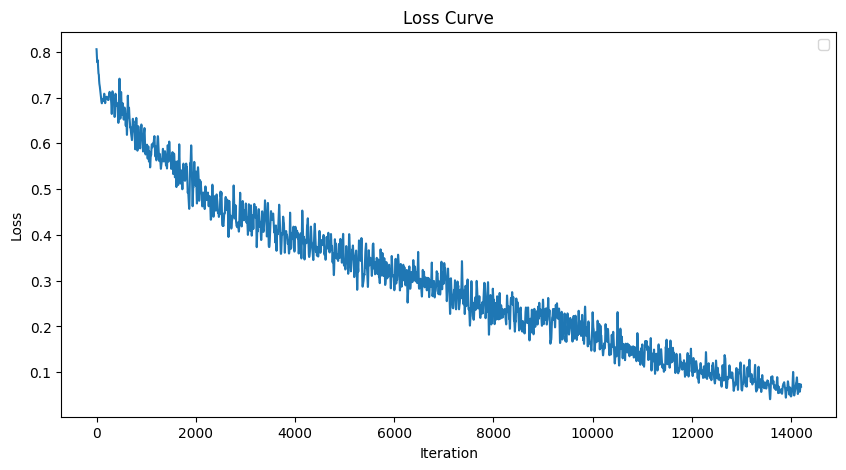

In [ ]:
#from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
#from statsmodels.nonparametric.smoothers_lowess import lowess

#print(loss_hist[len(loss_hist) - 5:len(loss_hist)])

fig = plt.figure(facecolor="w", figsize=(10, 5))
#plt.plot(np.convolve(loss_hist, np.ones(30)/30, mode='valid'))
#plt.plot(savgol_filter(loss_hist, window_length=100, polyorder=3))
#plt.plot(lowess(loss_hist, np.arange(len(loss_hist)), frac=0.1)[:, 1])
plt.plot(gaussian_filter1d(loss_hist, sigma=6))
#plt.plot(loss_hist)
#plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

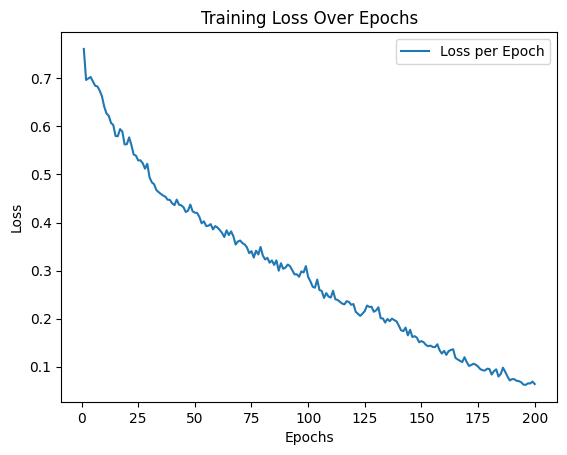

In [ ]:
num_epochs = train_config['num_epochs']
num_minibatches_per_epoch = len(loss_hist) // num_epochs

# Create x-axis values in terms of epochs
epochs = np.linspace(1, num_epochs, len(loss_hist))
epoch_losses = np.array(loss_hist).reshape(num_epochs, num_minibatches_per_epoch).mean(axis=1)

plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

C:\Users\knsve\AppData\Local\Temp\ipykernel_13368\1552820167.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


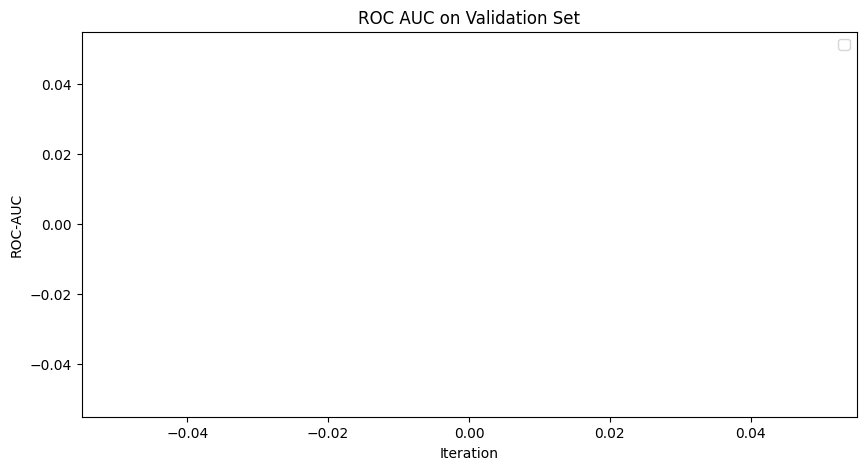

In [ ]:
# Validation Set
fig = plt.figure(facecolor="w", figsize=(10, 5))

#plt.plot(gaussian_filter1d(val_auc_hist, sigma=6))
plt.plot(val_auc_hist)
plt.title("ROC AUC on Validation Set")
plt.xlabel("Iteration")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()

#### Save Metrics

In [ ]:
metrics_np = np.zeros(12)

for i, metric in enumerate(results):
    metrics_np[i*2] = np.round(np.mean(metric), 3)
    metrics_np[i*2+1] = np.round(np.std(metric), 3)

# Print Results
print(f"Accuracy:  {metrics_np[0]:.3f} ± {metrics_np[1]:.3f}")
print(f"AUC ROC: {metrics_np[2]:.3f} ± {metrics_np[3]:.3f}")
print(f"Sensitivity: {metrics_np[4]:.3f} ± {metrics_np[5]:.3f}")
print(f"Specificity: {metrics_np[6]:.3f} ± {metrics_np[7]:.3f}")

metric_names = ['Acc', 'AUC', 'Sn', 'Sp', 'F1', 'Precision']
metrics_np = metrics_np.reshape(1, -1)
columns = []
for name in metric_names:
    columns.extend([f'Mean {name}', f'Std {name}'])


df_metrics = pd.DataFrame(metrics_np, columns=columns)
num_hidden = net_config['num_hidden']
time_steps = train_config['num_steps']
num_epochs = train_config['num_epochs']

# TODO: Add neuron thresholds to name
filename = make_filename(dirname, target_name, net_type, data_config, lr, weight_decay, optim_type, net_config, train_config, model)
if save_csv: df_metrics.to_csv(filename, index=False)

print(filename)

In [ ]:
results[1]

[0.6648756218905472,
 0.6594758064516129,
 0.5915492957746479,
 0.7059701492537314,
 0.5830851697438951,
 0.5598570577724836,
 0.6482142857142857,
 0.6182926829268292,
 0.6587735276259866,
 0.6502487562189055,
 0.6793034825870646,
 0.5964912280701755,
 0.6180429977898333,
 0.640361326186222,
 0.5434609250398723,
 0.6108903020667726,
 0.5530303030303031,
 0.6385074626865671,
 0.6055555555555556,
 0.6508413461538461,
 0.6609092713917015,
 0.6337301587301587,
 0.5593731163351416,
 0.617845786963434,
 0.6753968253968254,
 0.5777222777222777,
 0.6038306451612904,
 0.6498894916616436,
 0.6053847699417321,
 0.6598837209302326]

In [ ]:
min_auc = np.argmin(results[1])
print("min auc:", results[1][min_auc], "at", min_auc)

max_auc = np.argmax(results[1])
print("max auc:", results[1][max_auc], "at", max_auc)